In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
from scipy.signal import find_peaks, argrelextrema
from scipy.optimize import curve_fit
import os
import re
from pathlib import Path
import scienceplots

In [19]:
def load_gyro(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows, usecols=[0, 1, 2])
    # Rename the columns based on the file format
    df.columns = ['GYRO X (deg/s)', 'GYRO Y (deg/s)', 'GYRO Z (deg/s)']
    df = df.apply(pd.to_numeric, errors='coerce')

    # Remove columns with nan values
    df = df.dropna()
    return df

def load_acc(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows, usecols=[0, 1, 2])
    # Rename the columns based on the file format
    df.columns = ['ACC X (G)', 'ACC Y (G)', 'ACC Z (G)']
    df = df.apply(pd.to_numeric, errors='coerce')

    # Remove columns with nan values
    df = df.dropna()
    return df

def load_emg(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows, usecols=[0])
    # Rename the columns based on the file format
    df.columns = ['EMG 1 (mV)']
    df = df.apply(pd.to_numeric, errors='coerce')

    # Remove columns with nan values
    df = df.dropna()
    return df

def load_log(file_path, imu):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows)
    # Rename the columns based on the file format
    if imu:
        df.columns = ['Tag', 'Segment Start Index', 'Segment End Index', 'Start Time', 'End Time', 'Unassisted Mean']
    else:
        df.columns = ['Tag', 'Start Time', 'End Time', 'Score', 'Unassisted Mean', 'Segment Length', 'Unassisted']
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def load_or(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows)
    # Rename the columns based on the file format
    df.columns = ['OR W', 'OR X', 'OR Y', 'OR Z']
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def load(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows)
    # Rename the columns based on the file format
    # df.columns = ['1']
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

In [10]:
def apply_lowpass_filter(df: pd.DataFrame, cutoff_freq: float, sampling_freq: float, filter_order=4) -> pd.DataFrame:
    """
    Apply a low-pass filter to the first 7 columns of the given DataFrame.

    Parameters:
    - df: pandas.DataFrame with the data to be filtered.
    - cutoff_freq: The cutoff frequency for the low-pass filter (in Hz).
    - sampling_freq: The sampling frequency of the data (in Hz).
    - filter_order: The order of the Butterworth filter (default is 4).

    Returns:
    - df_filtered: DataFrame with the low-pass filtered values.
    """
    # Normalize the cutoff frequency with respect to Nyquist frequency
    nyquist_freq = sampling_freq / 2
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Design a Butterworth low-pass filter
    b, a = sp.signal.butter(filter_order, normalized_cutoff, btype='low')

    # Create a copy of the DataFrame to hold the filtered data
    df_filtered = df.copy()

    # Apply the filter to data
    for col in df.columns:
        df_filtered[col] = sp.signal.filtfilt(b, a, df[col])

    return df_filtered


def filter_emg(unfiltered_df: pd.DataFrame, low_pass=4, sfreq=2000, high_band=20, low_band=450) -> pd.DataFrame:
    """ Filter EMG signals

    Args:
        unfiltered_df (pd.DataFrame): DataFrame containing the EMG data and time
        low_pass (int, optional): Low-pass cut off frequency. Defaults to 4.
        sfreq (int, optional): Sampling frequency. Defaults to 2000.
        high_band (int, optional): High-band frequency for bandpass filter. Defaults to 20.
        low_band (int, optional): Low-band frequency for bandpass filter. Defaults to 450.

    Returns:
        pd.DataFrame: filtered dataframe
    """
    emg_data = unfiltered_df.copy()

    # Normalize cut-off frequencies to sampling frequency
    high_band_normalized = high_band / (sfreq / 2)
    low_band_normalized = low_band / (sfreq / 2)
    low_pass_normalized = low_pass / (sfreq / 2)

    # Bandpass filter coefficients
    b1, a1 = sp.signal.butter(4, [high_band_normalized, low_band_normalized], btype='bandpass')

    # Lowpass filter coefficients
    b2, a2 = sp.signal.butter(4, low_pass_normalized, btype='lowpass')

    def process_emg(emg):
        # Handle NaNs: skip filtering for NaN segments
        if emg.isna().all():
            return emg  # Returns as is if all are NaNs

        # Correct mean for non-NaN values
        non_nan_emg = emg.dropna()
        emg_correctmean = non_nan_emg - non_nan_emg.mean()

        # Filter EMG: bandpass, rectify, lowpass for non-NaN values
        emg_filtered = sp.signal.filtfilt(b1, a1, emg_correctmean)
        emg_rectified = np.abs(emg_filtered)
        emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)

        # Construct the resulting series, placing NaNs back in their original positions
        result = pd.Series(index=emg.index, data=np.nan)
        result[emg.notna()] = emg_envelope

        return result

    # Apply processing to each column
    envelopes = emg_data.apply(process_emg, axis=0)
    env_freq = int(low_pass_normalized * sfreq)

    return envelopes, env_freq


In [310]:
def detect_peak_and_crop(df):
    df = df.iloc[2000:].reset_index(drop=True)

    # Detect the peak
    min_index = df["EMG VM_R"].idxmin()
    # Crop the data
    df = df.loc[min_index-200:].reset_index(drop=True)
    df = df.loc[:2500].reset_index(drop=True)

    return df, min_index

In [80]:
def plot_data(imu_df, emg_df, or_df, file_path, start, end):
    filename = os.path.basename(file_path).replace('.csv', '')

    # filter the imu data
    imu_df = apply_lowpass_filter(imu_df, 1, 519)

    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

    # Subplot for angular accelerations (ACC X, ACC Y, ACC Z)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC X (G)'], label='ACC X (G)')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Y (G)'], label='ACC Y (G)')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Z (G)'], label='ACC Z (G)')
    ax1.axvline(x=start, color='r', linestyle='--', label='Start')
    ax1.axvline(x=end, color='g', linestyle='--', label='End')
    ax1.set_ylabel('Angular Acceleration (G)')
    ax1.set_title('Angular Accelerations')
    ax1.legend()
    ax1.grid(True)

    # Subplot for angular velocities (GYRO X, GYRO Y, GYRO Z)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO X (deg/s)'], label='GYRO X (deg/s)')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Y (deg/s)'], label='GYRO Y (deg/s)')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Z (deg/s)'], label='GYRO Z (deg/s)')
    ax2.axvline(x=start, color='r', linestyle='--', label='Start')
    ax2.axvline(x=end, color='g', linestyle='--', label='End')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angular Velocity $(deg/s)$')
    ax2.set_title('Angular Velocities')
    ax2.legend()
    ax2.grid(True)

    # Subplot for roll angle
    ax3.plot(or_df['Time (s)'], or_df['roll_angle'], label='Roll Angle')
    ax3.axvline(x=start, color='r', linestyle='--', label='Start')
    ax3.axvline(x=end, color='g', linestyle='--', label='End')
    ax3.set_ylabel('Roll Angle $(rad)$')
    ax3.set_title('Roll Angle')
    ax3.legend()
    ax3.grid(True)

    # Subplot for EMG data
    ax4.plot(emg_df['Time (s)'], emg_df['EMG VM_R'], label='EMG VM_R')
    ax4.axvline(x=start, color='r', linestyle='--', label='Start')
    ax4.axvline(x=end, color='g', linestyle='--', label='End')
    ax4.set_ylabel('EMG (mV)')
    ax4.set_title('EMG Data')
    ax4.legend()
    ax4.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

In [81]:
def extract_time(df):
    """
    Detect the start and end of a sit-to-stand motion based on angular acceleration in z-axis.
    
    Parameters:
    - df: pandas.DataFrame with the data
    Returns:
    start_time (float): Time when the motion starts.
    end_time (float): Time when the motion ends.
    """
    # filter_freq = 3000/len(df)
    filter_freq = 1
    df = apply_lowpass_filter(df, filter_freq, 519)

    # Find the global minimum in X velocity
    minimum = np.argmin(df['GYRO X (deg/s)'])

    # First derivative (rate of change) to detect where the acceleration starts decreasing
    acc_z_diff = np.diff(df['ACC Z (G)'])
    # Find all acceleration-change extremas
    maxima = argrelextrema(acc_z_diff, np.greater)[0]
    # Get the two maxima closest to the global minimum
    maxima.sort()

    try:
        start_idx = maxima[np.searchsorted(maxima, minimum) - 1]

        # We need to have at least three maxima to be able to detect the end of the motion, as sometimes people might sit down to quickly
        # if len(maxima) > 2:
        #     end_idx = maxima[np.searchsorted(maxima, minimum)]
        # If there is no maxima, there will still always be a change of signs in the jerk
        # else:

        # Most robust way when only filtering segment
        gyro_x_diff = np.diff(df['GYRO X (deg/s)'])
        gyro_x_diff_diff = np.diff(gyro_x_diff)
        minima = argrelextrema(gyro_x_diff_diff, np.less)[0]
        end_idx = minima[np.searchsorted(minima, minimum)]
    except:
        return None, None

        # Backup plan (also works quite quite okay)
        # acc_z_diff_diff = np.diff(acc_z_diff)
        # acc_z_diff_diff_minima = argrelextrema(acc_z_diff_diff, np.less)[0]
        # # Select the minimum closest to the global minimum (higher than the global minimum)
        # end_idx = acc_z_diff_diff_minima[np.searchsorted(acc_z_diff_diff_minima, minimum)]


    # More debug plots
    # Acc Z
    # pdf = pd.DataFrame()

    # der = acc_z_diff
    # der = np.append(der, 0)
    # pdf["der"] = der*500

    # acc_z_diff_diff = np.diff(acc_z_diff)
    # der = acc_z_diff_diff
    # der = np.append(der, 0)
    # der = np.append(der, 0)
    # pdf["der2"] = der*200*500

    # pdf["ACC Z (G)"] = df['ACC Z (G)'][:len(acc_z_diff)+1]

    # pdf["der"].plot()
    # pdf["der2"].plot()
    # pdf["ACC Z (G)"].plot()
    # plt.show()
    

    # Gyro X
    # pdf = pd.DataFrame()

    # gyro_x_diff = np.diff(df['GYRO X (deg/s)'])
    # der = gyro_x_diff
    # der = np.append(der, 0)
    # pdf["der"] = der*500

    # gyro_x_diff_diff = np.diff(gyro_x_diff)
    # der = gyro_x_diff_diff
    # der = np.append(der, 0)
    # der = np.append(der, 0)
    # pdf["der2"] = der*200*500

    # pdf["GYRO X (deg/s)"] = df['GYRO X (deg/s)'][:len(gyro_x_diff)+1]

    # pdf["der"].plot()
    # pdf["der2"].plot()
    # pdf["GYRO X (deg/s)"].plot()
    # plt.show()
    
    return start_idx, end_idx

In [82]:
def segmentation(imu_df, emg_df, or_df, plot_path):
    """
    Segmentation of incoming data based on angular acceleration in z-axis.
    Parameters:
    - imu_df: pandas.DataFrame with the imu data
    Returns:
    - df_segmented: DataFrame with the segmented data.
    """

    intermediate_df = imu_df.copy()
    filtered_intermediate_df = apply_lowpass_filter(intermediate_df, 1, 519)

    # Find maxima in angular velocity in x-axis, that exceed a certain threshold
    maxima = find_peaks(filtered_intermediate_df['GYRO X (deg/s)'], height=50)[0]

    # Add first and last index to the maxima list
    maxima = np.insert(maxima, 0, 0)
    maxima = np.append(maxima, len(imu_df)-1)
    

    all_start = []
    all_end = []

    # Extract relevant times between two maxima
    for i in range(len(maxima)-1):
        start_idx = maxima[i]
        end_idx = maxima[i+1]

        # Create a new dataframe with the relevant data
        imu_df_segmented = imu_df.iloc[start_idx:end_idx].reset_index(drop=True)

        # Extract the start and end index of the motion
        start_idx2, end_idx2 = extract_time(imu_df_segmented)

        if start_idx2 is not None and end_idx2 is not None:
            # Calculate some score of the emg data during the motion
            # relevant_emg = imu_df_segmented.iloc[start_idx2:end_idx2].reset_index(drop=True)

            start_time = imu_df_segmented['Time (s)'][start_idx2]
            end_time = imu_df_segmented['Time (s)'][end_idx2]
            # plot_data(imu_df, emg_df, or_df, plot_path, start_time, end_time)

            all_start.append(start_time)
            all_end.append(end_time)
            # all_start.append(start_idx2)
            # all_end.append(end_idx2)

    return all_start, all_end

In [83]:
def or_segmentation(imu_df, emg_df, or_df, plot_path):
    # Get minumum and maximum roll angle and then segement based on that
    min_roll = 0.12
    max_roll = or_df['roll_angle'].max() - 0.05
    max_roll = 1.4

    minima = []
    peaks = []

    for i, value in enumerate(or_df['roll_angle']):
        if i > 0:
            if value > min_roll and or_df['roll_angle'][i-1] <= min_roll:
                minima.append(i)
            if or_df['roll_angle'][i-1] <= max_roll and value > max_roll:
                peaks.append(i)

    # remove last minimum if no peak after
    if len(minima) > len(peaks):
        minima = minima[:-1]

    # plot the or and all peaks
    # plt.plot(or_df['Time (s)'], or_df['roll_angle'])
    # plt.plot(or_df['Time (s)'][peaks], or_df['roll_angle'][peaks], "x")
    # plt.plot(or_df['Time (s)'][minima], or_df['roll_angle'][minima], "o")
    # plt.show()

    return minima, peaks

In [314]:
def plot_collected_data(imu_df, emg_df, log_df, or_df, save_path, i, two, yes):
    linewidth = 2
    linewidth_2 = 1
    fontsize = 14

    color_values = np.linspace(0.0, 0.6, 8)  # Higher subplot -> Higher colormap value
    colors = [cm.plasma(value) for value in color_values]

    start_alpha = 0.7
    end_alpha = 0.4


    # invert order of colors
    # colors = colors[::-1]

    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
    plt.style.use('science')

    # Subplot for angular accelerations (ACC X, ACC Y, ACC Z)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC X (G)'], label='ACC X', linewidth=linewidth, color=colors[0], alpha=0.5)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Y (G)'], label='ACC Y', linewidth=linewidth, color=colors[1], alpha=0.5)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Z (G)'], label='ACC Z', linewidth=linewidth, color=colors[2])
    ax1.set_ylabel('Acceleration\n$[deg/s^2]$', fontsize=fontsize)
    ax1.set_ylim(top=1.2)
    # ax1.set_ylim(-1.8, 1.5)
    # ax1.set_title('Angular Accelerations')
    # ax1.legend(fontsize=fontsize)
    # ax1.grid(True)

    # Subplot for angular velocities (GYRO X, GYRO Y, GYRO Z)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO X (deg/s)'], label='GYRO X', linewidth=linewidth, color=colors[3])
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Y (deg/s)'], label='GYRO Y', linewidth=linewidth, color=colors[4], alpha=0.5)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Z (deg/s)'], label='GYRO Z', linewidth=linewidth, color=colors[5], alpha=0.5)
    # ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Velocity\n$[deg/s]$', fontsize=fontsize)
    # ax2.set_ylim(-180, 120)
    # ax2.set_title('Angular Velocities')
    # ax2.legend(fontsize=fontsize)
    # ax2.grid(True)

    # Subplot for roll angle
    ax3.plot(or_df['Time (s)'], or_df['roll_angle'], label='Roll Angle', linewidth=linewidth, color=colors[6])
    ax3.set_ylabel('Roll Angle\n$[rad]$', fontsize=fontsize)
    # ax3.set_ylim(-0.2, 1.6)
    # ax3.set_title('Roll Angle')
    # ax3.legend(fontsize=fontsize)
    # ax3.grid(True)

    # Subplot for EMG data
    ax4.plot(emg_df['Time (s)'], emg_df['EMG VM_R'], label='EMG', linewidth=linewidth+1, color="orchid")
    ax4.set_xlabel('Time $[s]$', fontsize=fontsize)
    ax4.set_ylabel('EMG\n$[mV]$', fontsize=fontsize)
    # ax4.set_title('EMG Data')
    # ax4.legend(fontsize=fontsize)
    # ax4.grid(True)

    
    # Add vertical lines for each segment start and end from log_df
    for i, row in log_df.iterrows():
        if two:
            segment_start = row['Segment Start Index']
            segment_end = row['Segment End Index']
            sts_start = row['Start Time'] + segment_start
            sts_end = row['End Time'] + segment_start

            # Same color for both start and end in each column
            start_color = 'black' 
            end_color = 'black' 
        else:
            sts_start = row['Start Time']
            sts_end = row['End Time']
        
        sts_start_color = 'black' 
        sts_end_color = 'black' 

        # Plot on all axes

        ax1.axvline(x=sts_start, color=sts_start_color, linestyle='--', label='Motion Start' if i == 0 else "", linewidth=linewidth, alpha=start_alpha)
        ax1.axvline(x=sts_end, color=sts_end_color, linestyle='--', label='Motion End' if i == 0 else "", linewidth=linewidth, alpha=end_alpha)
        ax1.annotate('',
            xy=(sts_start, 1.1), 
            xytext=(sts_end, 1.1), 
            arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5),
            ha='center', va='bottom', fontsize=12, fontweight='bold'
        )
        ax1.text((sts_start+sts_end)/2, 1.2, 'Sit-to-Stand', ha='center', va='bottom', fontsize=12, fontweight='bold')

        ax2.axvline(x=sts_start, color=sts_start_color, linestyle='--', label='Motion Start' if i == 0 else "", linewidth=linewidth, alpha=start_alpha)
        ax2.axvline(x=sts_end, color=sts_end_color, linestyle='--', label='Motion End' if i == 0 else "", linewidth=linewidth, alpha=end_alpha)

        ax3.axvline(x=sts_start, color=sts_start_color, linestyle='--', label='Motion Start' if i == 0 else "", linewidth=linewidth, alpha=start_alpha)
        ax3.axvline(x=sts_end, color=sts_end_color, linestyle='--', label='Motion End' if i == 0 else "", linewidth=linewidth, alpha=end_alpha)

        ax4.axvline(x=sts_start, color=start_color, linestyle='--', label='Motion Start' if i == 0 else "", linewidth=linewidth, alpha=start_alpha)
        ax4.axvline(x=sts_end, color=end_color, linestyle='--', label='Motion End' if i == 0 else "", linewidth=linewidth, alpha=end_alpha)

        # if two:
        #     for ax in [ax1, ax2, ax3, ax4]:  # Loop through all axes
        #         # ax.axvline(x=segment_start, color=start_color, linestyle='-', label='Segment Start' if i == 0 else "", linewidth=linewidth_2)
        #         # ax.axvline(x=segment_end, color=end_color, linestyle='-', label='Segment End' if i == 0 else "", linewidth=linewidth_2)
                
        #         # Fill the area between segment_start and segment_end
        #         # ax.axvspan(segment_start, segment_end, color='black', alpha=0.8, zorder=0)  # Adjust alpha for transparency

        #         # Fill the are before segment_start and after segment_end
        #         ax.axvspan(min(imu_df["Time (s)"]), segment_start, color='grey', alpha=0.4, zorder=0)
        #         ax.axvspan(segment_end, max(imu_df["Time (s)"]), color='grey', alpha=0.4, zorder=0)

    # move legends to bottom right
    ax1.legend(loc='lower right', bbox_to_anchor=(1.2, 0), frameon=False)
    ax2.legend(loc='lower right', bbox_to_anchor=(1.21, 0), frameon=False)

    # Show plot
    plt.tight_layout()
    # plt.subplots_adjust(right=0.8)
    # save the plot as a file
    filename = save_path / f'segmented_data_{i}.png'
    plt.savefig(filename, dpi=500)  # Save with specified resolution
    plt.close()
    # plt.show()

In [313]:
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_Test_IMU_seg/February_20/EMG/Raw")
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_Optimization_Dom/February_21/EMG/RAW")
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_test_mixed_processing/February_21/EMG/RAW")
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_IMU_seg/February_21/EMG/RAW")
folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_mean_opt_1rep/February_04/EMG/Raw")

save_path = folder_path.parent.parent / "plots" / "Segmentation"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# trial = "Trial_2"

unpowered_normalized_area_all = {"Before":[], "After":[]}
powered_normalized_area_all = []


for trialnumber in [6]:
    trial = "Trial_" + str(trialnumber)
    # Iterate thorugh folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                if trial in file and not "MVIC" in file:
                    file_path = os.path.join(folder_path, file)
                    # Data from API
                    if "GYRO" in file:
                        gyro_path = file_path
                    if "ACC" in file:
                        acc_path =  file_path
                    if "EMG" in file:
                        emg_path =  file_path
                    if "OR" in file:
                        if "Debug" not in file:
                            or_path =  file_path

    # join paths
    log_path = os.path.join(folder_path.parent.parent, "Log")

    for root, dirs, files in os.walk(log_path):
        for file in files:
            if file.endswith(".csv"):
                if trial in file:
                    log_file = os.path.join(log_path, file)


    gyro_df = load_gyro(gyro_path)
    acc_df = load_acc(acc_path)
    emg_df = load(emg_path)
    or_df = load_or(or_path)
    log_df = load(log_file)

    # Drop EMG OR and EMG IMU columns
    emg_df = emg_df.drop(columns=['EMG OR', 'EMG IMU'])
    emg_df = emg_df.dropna().reset_index(drop=True)

    # Filter the emg data
    emg_df, _ = filter_emg(emg_df, sfreq=2148.259)

    # Concatenate the dataframes
    imu_df = pd.concat([gyro_df, acc_df], axis=1)

    # filter imu data
    imu_df = apply_lowpass_filter(imu_df, 1, 519)

    imu_time_interval = 1 / 518.519  # Time step based on ACC X sampling rate
    imu_df['Time (s)'] = imu_df.index * imu_time_interval

    # emg_time_interval = 1 / 1259.2593 # Time step based on EMG sampling rate
    emg_time_interval = 1 / 2148.259 # Time step based on EMG sampling rate$
    emg_df['Time (s)'] = emg_df.index * emg_time_interval  # Create a time column for EMG data

    or_time_interval = 1 / 222.22 # Time step based on EMG sampling rate
    or_df['Time (s)'] = or_df.index * or_time_interval  # Create a time column

    or_df["roll_angle"] = -np.arctan2(2 * (or_df['OR W'] * or_df['OR X'] + or_df['OR Y'] * or_df['OR Z']), 1 - 2 * (or_df['OR X'] ** 2 + or_df['OR Y'] ** 2))

    # Convert log entries to time
    log_df['Start Time'] = log_df['Start Time'] * imu_time_interval
    log_df['End Time'] = log_df['End Time'] * imu_time_interval
    log_df['Segment Start Index'] = log_df['Segment Start Index'] * imu_time_interval
    log_df['Segment End Index'] = log_df['Segment End Index'] * imu_time_interval

    # # GO through log and crop and plot data according to log semgents
    for i, row in log_df.iterrows():
        if i > 1 and i < 5:
            # start = row['Start Time']
            # end = row['End Time'] + 2
            start = row['Segment Start Index'] - 2
            end = row['Segment End Index'] + 2

            # crop emg and imu data
            emg_df_cropped = emg_df[(emg_df['Time (s)'] >= start) & (emg_df['Time (s)'] <= end)]
            imu_df_cropped = imu_df[(imu_df['Time (s)'] >= start) & (imu_df['Time (s)'] <= end)]
            or_df_cropped = or_df[(or_df['Time (s)'] >= start) & (or_df['Time (s)'] <= end)]

            # convert row to dataframe
            row_df = pd.DataFrame(row).T
        
            # Plot the data
            plot_collected_data(imu_df_cropped, emg_df_cropped, row_df, or_df_cropped, save_path, i, True, True)

    # plot_collected_data(imu_df, emg_df, log_df, or_df, file_path, 1, True, True)


KeyError: 'Segment Start Index'

In [311]:
# For OR logging (different)

# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_Test_OR_seg/February_20/EMG/Raw")
folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_mean_opt_1rep/February_04/EMG/Raw")

save_path = folder_path.parent.parent / "plots" / "Segmentation"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# trial = "Trial_2"

unpowered_normalized_area_all = {"Before":[], "After":[]}
powered_normalized_area_all = []


for trialnumber in [3]:
    trial = "Trial_" + str(trialnumber)
    # Iterate thorugh folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                if trial in file and not "MVIC" in file:
                    file_path = os.path.join(folder_path, file)
                    # Data from API
                    if "GYRO" in file:
                        gyro_path = file_path
                    if "ACC" in file:
                        acc_path =  file_path
                    if "EMG" in file:
                        emg_path =  file_path
                    if "OR" in file:
                        if "Debug" not in file:
                            or_path =  file_path

    # join paths
    log_path = os.path.join(folder_path.parent.parent, "Log")

    for root, dirs, files in os.walk(log_path):
        for file in files:
            if file.endswith(".csv"):
                if trial in file:
                    log_path = os.path.join(log_path, file)


    gyro_df = load_gyro(gyro_path)
    acc_df = load_acc(acc_path)
    emg_df = load(emg_path)
    or_df = load_or(or_path)
    log_df = load_log(log_path, False)

    # Drop EMG OR and EMG IMU columns
    emg_df = emg_df.drop(columns=['EMG OR', 'EMG IMU'])
    emg_df = emg_df.dropna().reset_index(drop=True)

    # Concatenate the dataframes
    imu_df = pd.concat([gyro_df, acc_df], axis=1)

    # filter imu data
    imu_df = apply_lowpass_filter(imu_df, 1, 519)

    imu_time_interval = 1 / 518.519  # Time step based on ACC X sampling rate
    imu_df['Time (s)'] = imu_df.index * imu_time_interval

    # emg_time_interval = 1 / 1259.2593 # Time step based on EMG sampling rate
    emg_time_interval = 1 / 2148.259 # Time step based on EMG sampling rate$
    emg_df['Time (s)'] = emg_df.index * emg_time_interval  # Create a time column for EMG data

    or_time_interval = 1 / 222.22 # Time step based on EMG sampling rate
    or_df['Time (s)'] = or_df.index * or_time_interval  # Create a time column

    or_df["roll_angle"] = -np.arctan2(2 * (or_df['OR W'] * or_df['OR X'] + or_df['OR Y'] * or_df['OR Z']), 1 - 2 * (or_df['OR X'] ** 2 + or_df['OR Y'] ** 2))

    # Convert log entries to time
    log_df['Start Time'] = log_df['Start Time'] * emg_time_interval
    log_df['End Time'] = log_df['End Time'] * emg_time_interval

    # Initialize columns with NaN
    log_df['Segment Start Index'] = np.zeros(len(log_df))
    log_df['Segment End Index'] = np.zeros(len(log_df))

    # Swap Semgent Start Index and Start Index
    log_df['Segment Start Index'], log_df['Start Time'] = log_df['Start Time'], log_df['Segment Start Index']
    log_df['Segment End Index'], log_df['End Time'] = log_df['End Time'], log_df['Segment End Index']

    # Process each row
    for i, row in log_df.iterrows():
        segment_start = row['Segment Start Index']
        segment_end = row['Segment End Index']

        # Crop the data
        emg_df_segmented = emg_df.loc[(emg_df['Time (s)'] > segment_start) & (emg_df['Time (s)'] < segment_end)] #.reset_index(drop=True)

        # Filter the EMG data
        emg_df_segmented, _ = filter_emg(emg_df_segmented, sfreq=2148.259)

        # Detect peak and crop
        _, min_idx = detect_peak_and_crop(emg_df_segmented)

        # Ensure min_idx is within valid bounds
        start = max(0, min_idx - 200) + 2000
        # start = min_idx
        end = min_idx + 2500 + 2000

        # Assign to DataFrame
        log_df.at[i, 'Start Time'] = start
        log_df.at[i, 'End Time'] = end

        # # reset emg time
        # emg_df_segmented['Time (s)'] = emg_df_segmented.index * emg_time_interval

        # # convert start and end to time
        # start *= emg_time_interval
        # end *= emg_time_interval    
        # # Plot emg with start and end
        # plt.plot(emg_df_segmented['Time (s)'], emg_df_segmented['EMG VM_R'])
        # plt.vlines(segment_start+start, emg_df_segmented['EMG VM_R'].min(), emg_df_segmented['EMG VM_R'].max(), colors='r', linestyles='dashed')
        # plt.vlines(segment_start+end, emg_df_segmented['EMG VM_R'].min(), emg_df_segmented['EMG VM_R'].max(), colors='g', linestyles='dashed')
        # plt.show()

    # Convert indices to time
    log_df['Start Time'] *= emg_time_interval
    log_df['End Time'] *= emg_time_interval

    # Filter the emg data
    emg_df, _ = filter_emg(emg_df, sfreq=2148.259)
    # New time column
    emg_df['Time (s)'] = emg_df.index * emg_time_interval

    # Plot the data
    for i, row in log_df.iterrows():
        if i > 1 and i < 5:
            start = row['Segment Start Index'] -2
            end = row['Segment End Index'] +2

            # crop emg and imu data
            emg_df_cropped = emg_df[(emg_df['Time (s)'] >= start) & (emg_df['Time (s)'] <= end)]
            imu_df_cropped = imu_df[(imu_df['Time (s)'] >= start) & (imu_df['Time (s)'] <= end)]
            or_df_cropped = or_df[(or_df['Time (s)'] >= start) & (or_df['Time (s)'] <= end)]

            # convert row to dataframe
            row_df = pd.DataFrame(row).T
        
            # Plot the data
            plot_collected_data(imu_df_cropped, emg_df_cropped, row_df, or_df_cropped, save_path, i, True, True)

    # plot_collected_data(imu_df, emg_df, log_df, or_df, file_path, 1, True, True)


### Segmented_data

In [79]:
def plot_segmented_data(imu_df, emg_df, file_path):
    filename = os.path.basename(file_path).replace('.csv', '')
    folder_path = os.path.dirname(file_path)

    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    # Subplot for angular accelerations (ACC X, ACC Y, ACC Z)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC X'], label='ACC X (G)')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Y'], label='ACC Y (G)')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Z'], label='ACC Z (G)')
    ax1.set_ylabel('Angular Acceleration (G)')
    ax1.set_title('Angular Accelerations')
    ax1.legend()
    ax1.grid(True)

    # Subplot for angular velocities (GYRO X, GYRO Y, GYRO Z)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO X'], label='GYRO X (deg/s)')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Y'], label='GYRO Y (deg/s)')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Z'], label='GYRO Z (deg/s)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angular Velocity (deg/s)')
    ax2.set_title('Angular Velocities')
    ax2.legend()
    ax2.grid(True)


    # Subplot for EMG data
    ax4.plot(emg_df['Time (s)'], emg_df['EMG VM_R'], label='EMG VM_R')
    ax4.set_ylabel('EMG (mV)')
    ax4.set_title('EMG Data')
    ax4.legend()
    ax4.grid(True)

    # Show plot
    plt.tight_layout()
    # save the plot as a file
    # plt.savefig(os.path.join(file_path, 's1.png'))
    plt.show()

5059


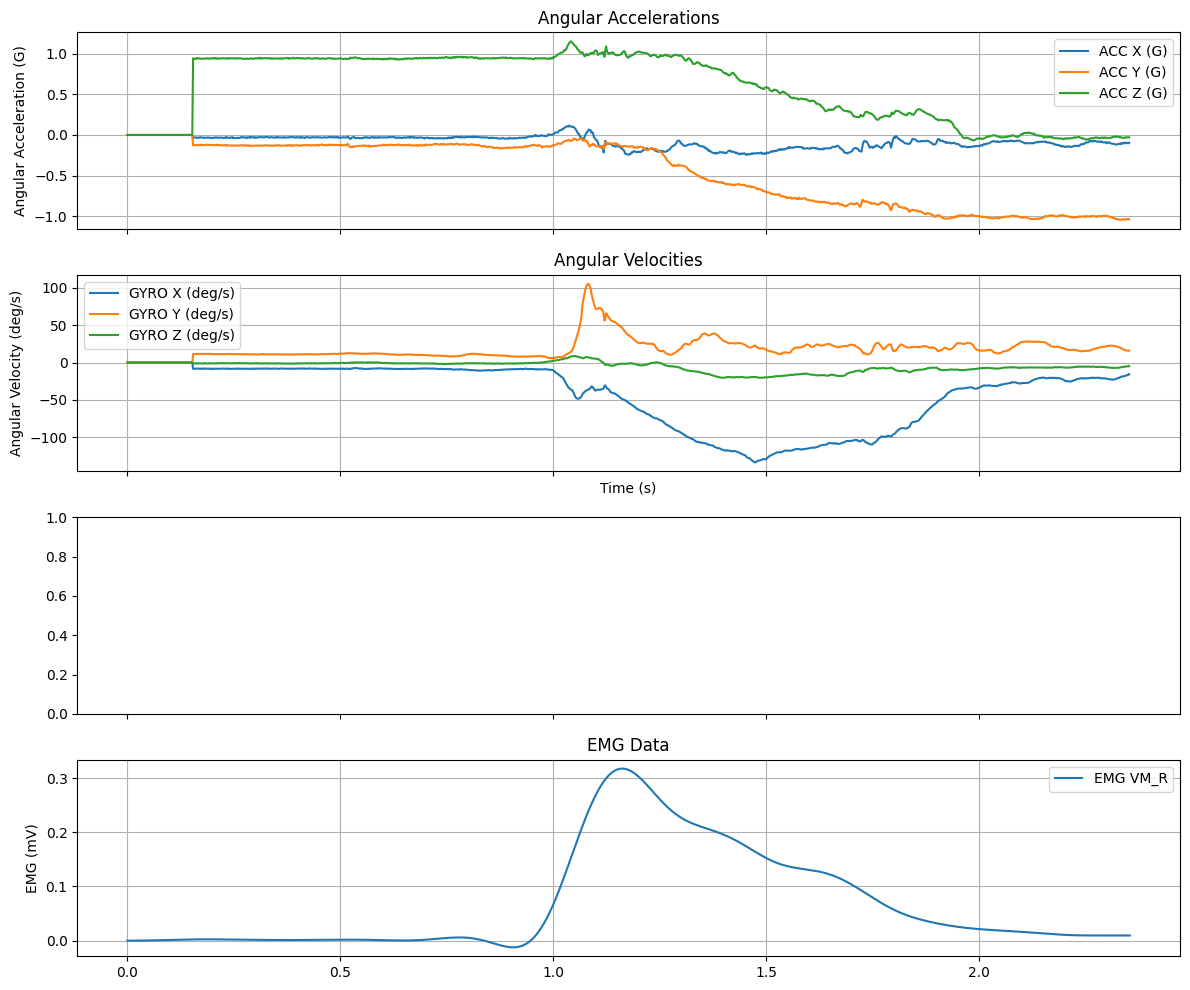

2718


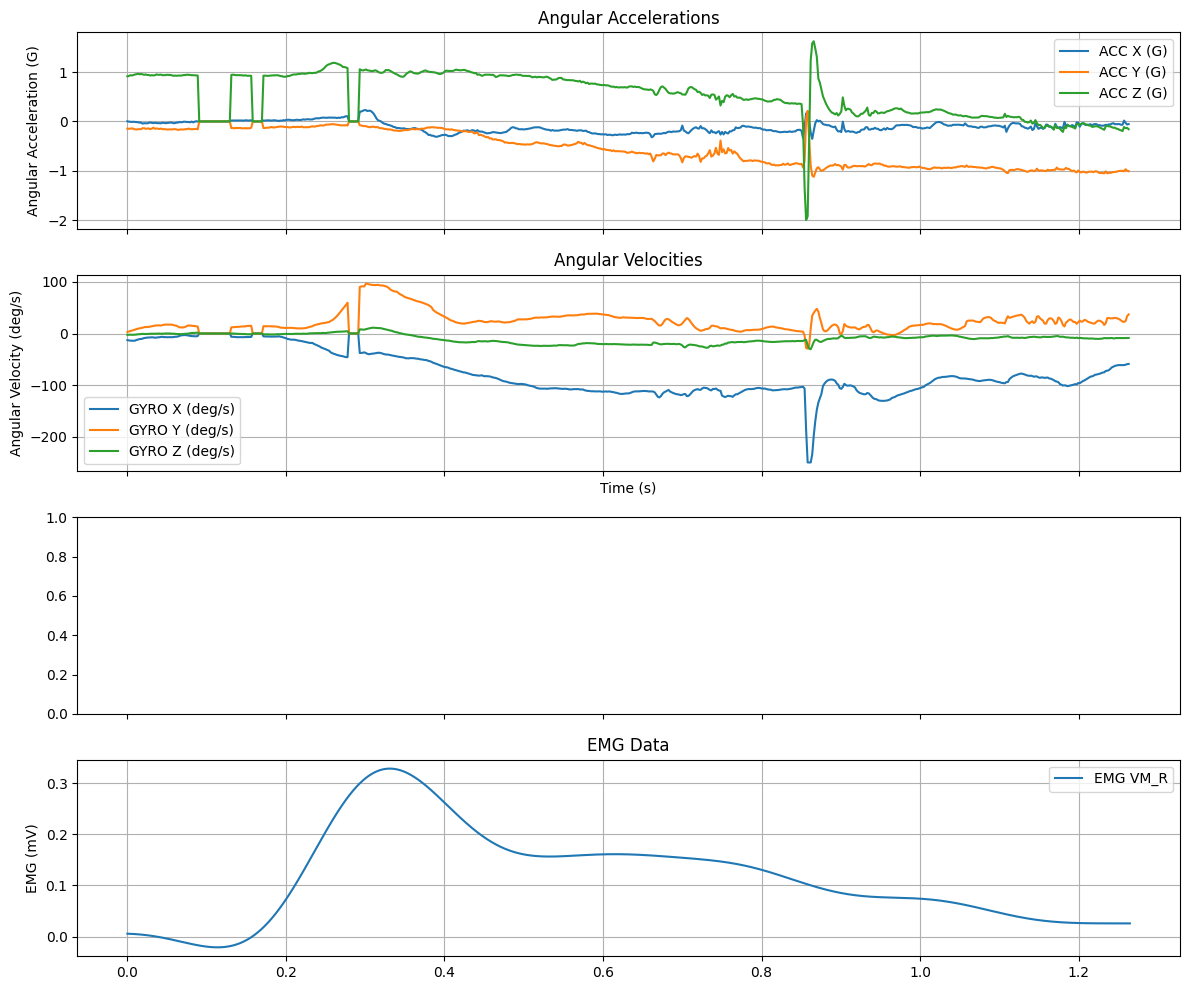

3294


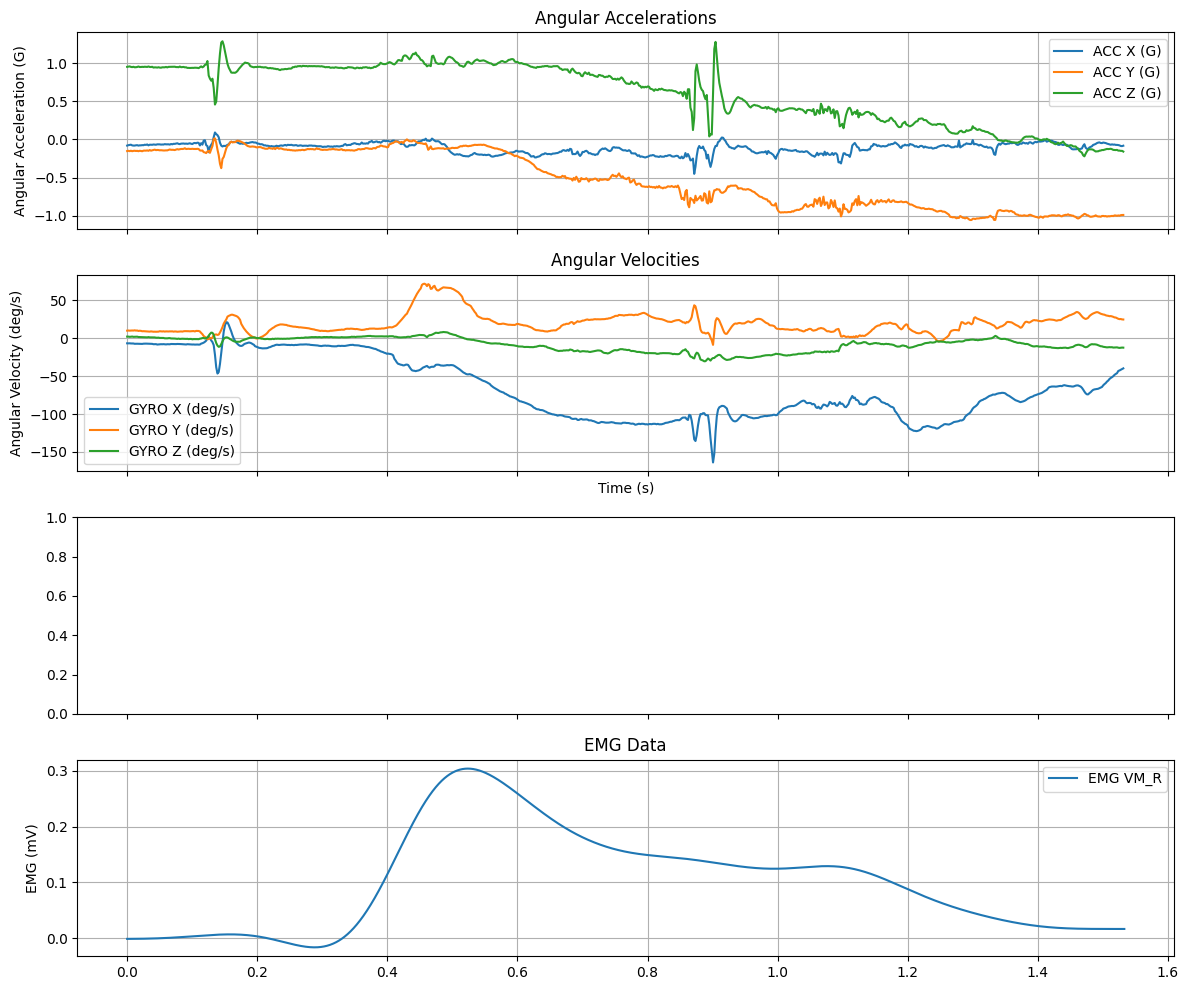

3410


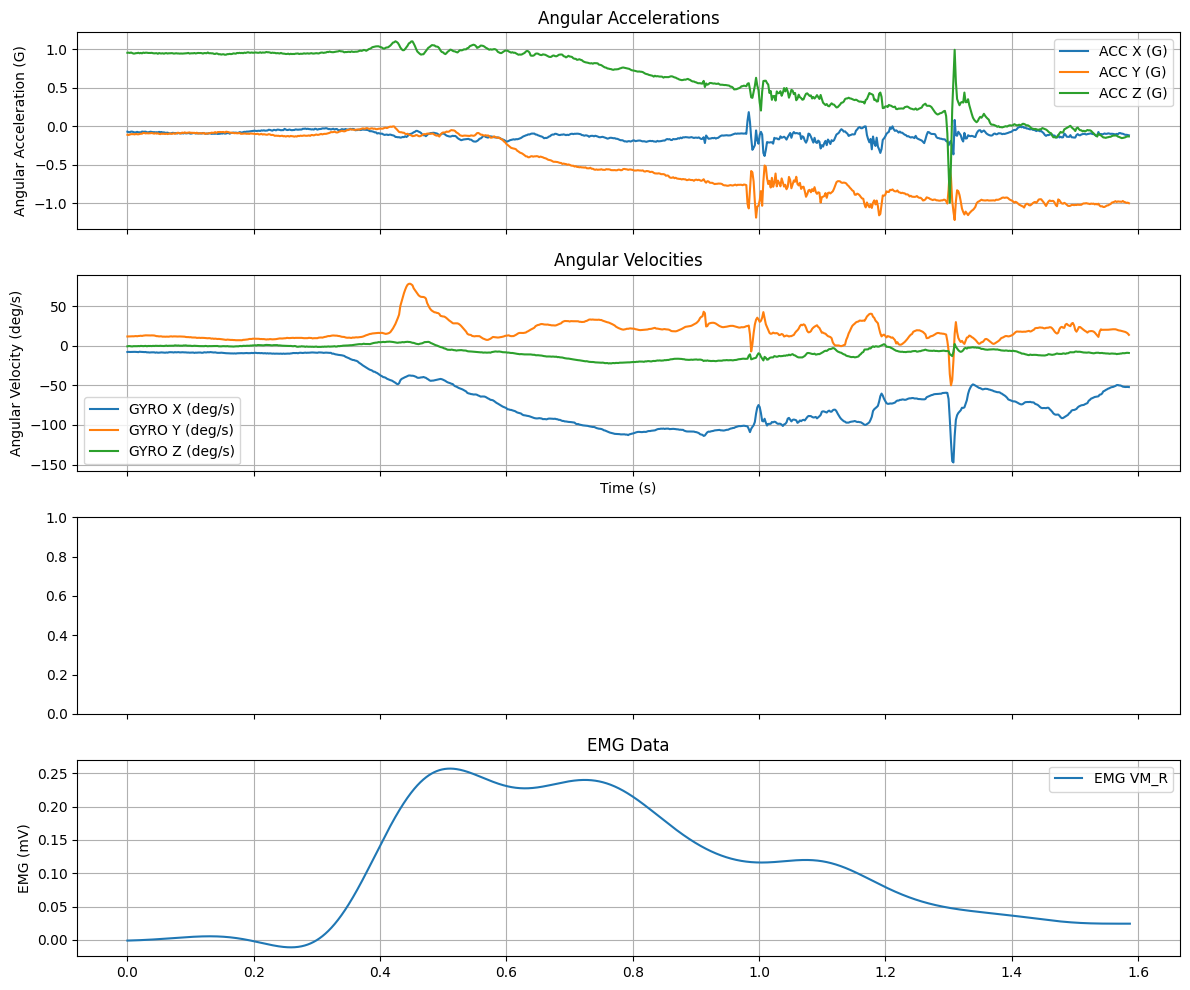

3169


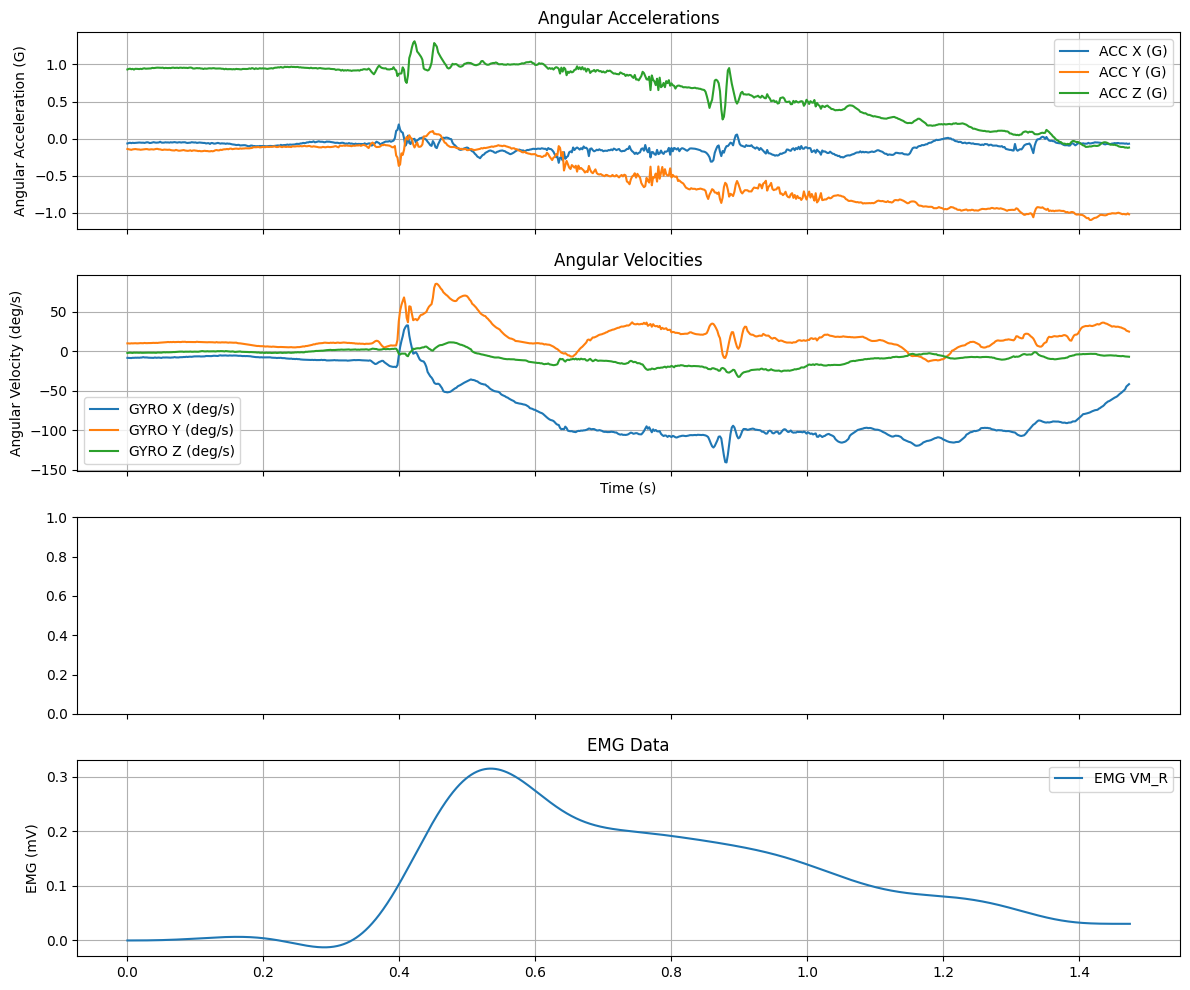

3074


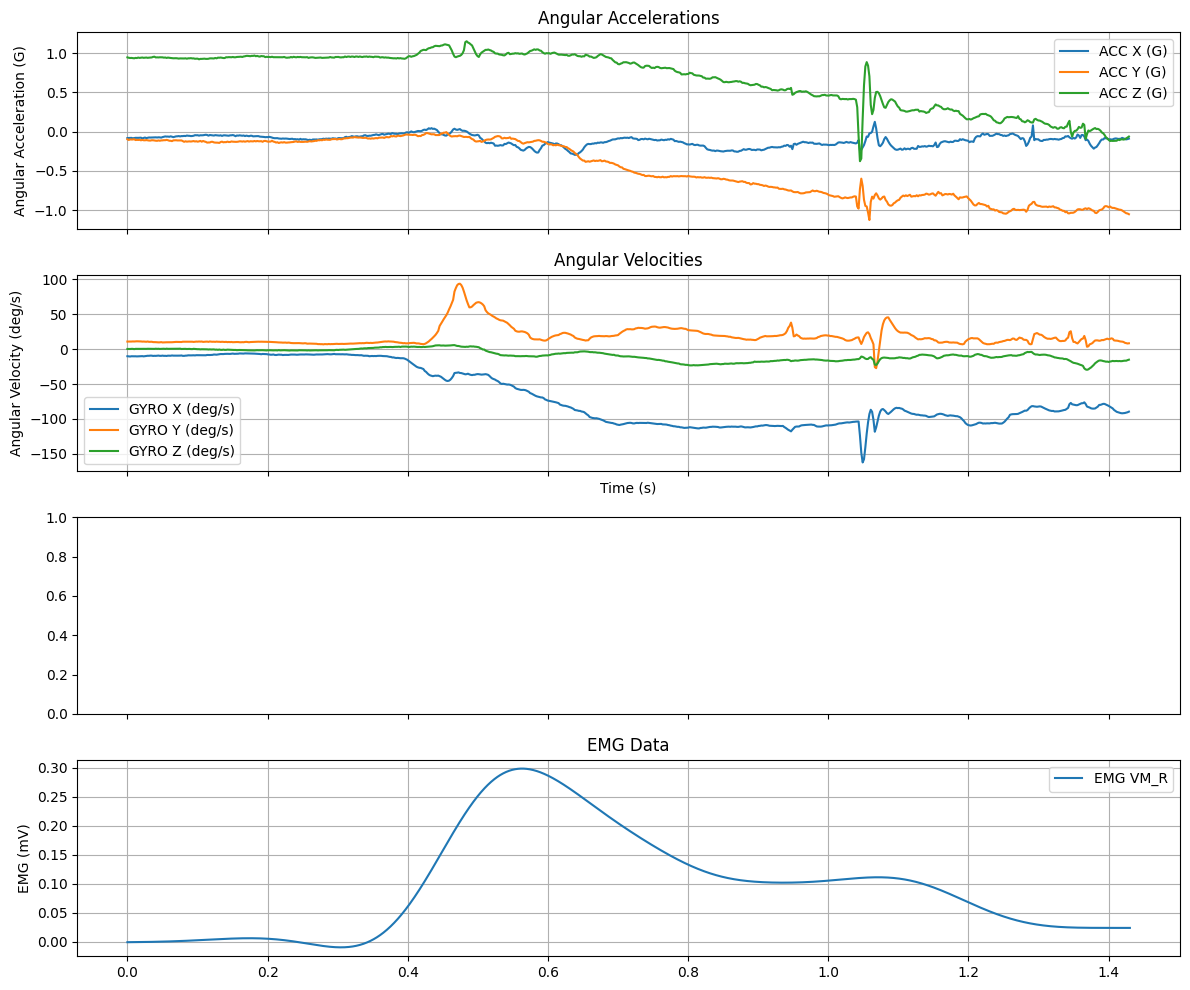

12657


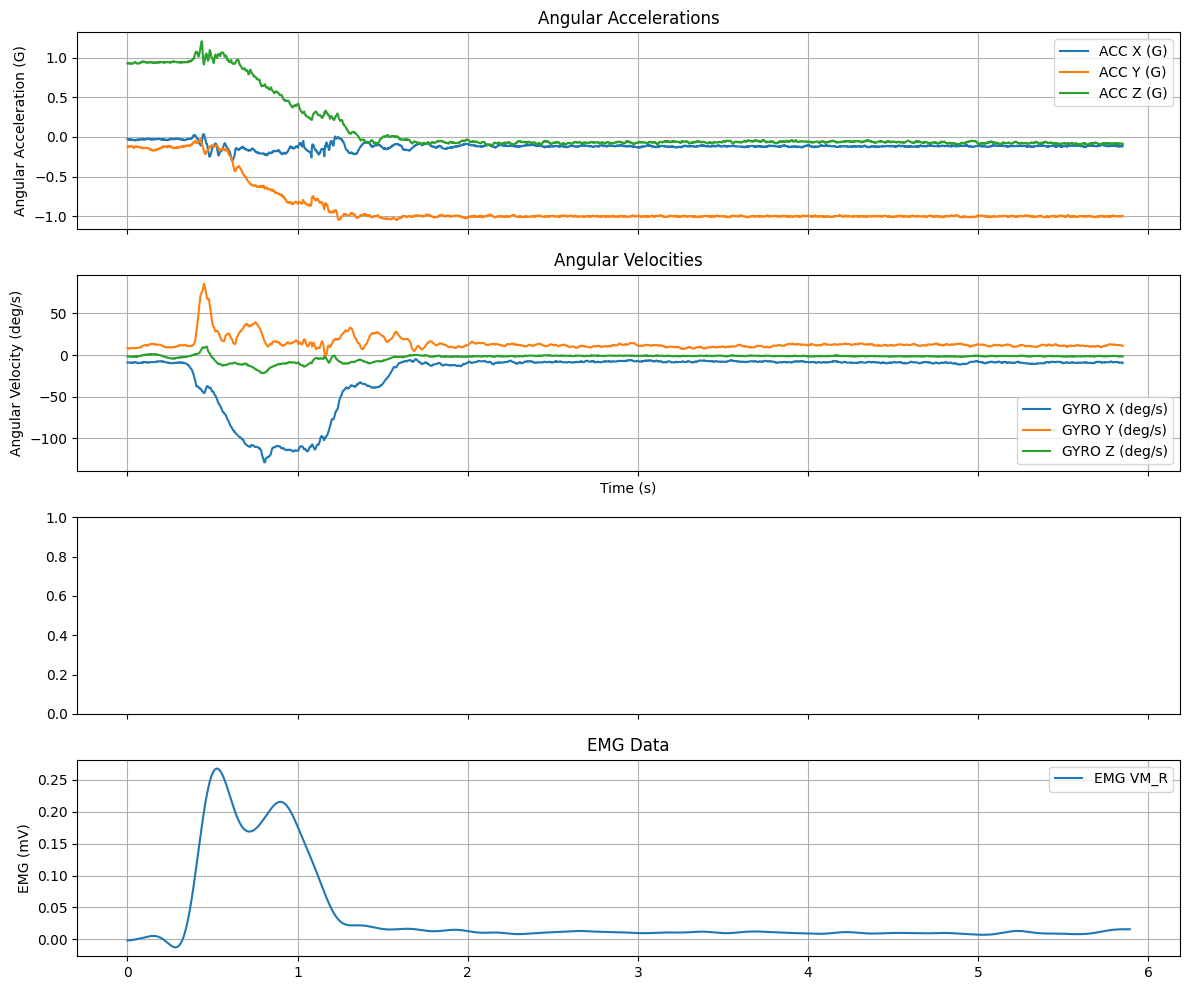

3327


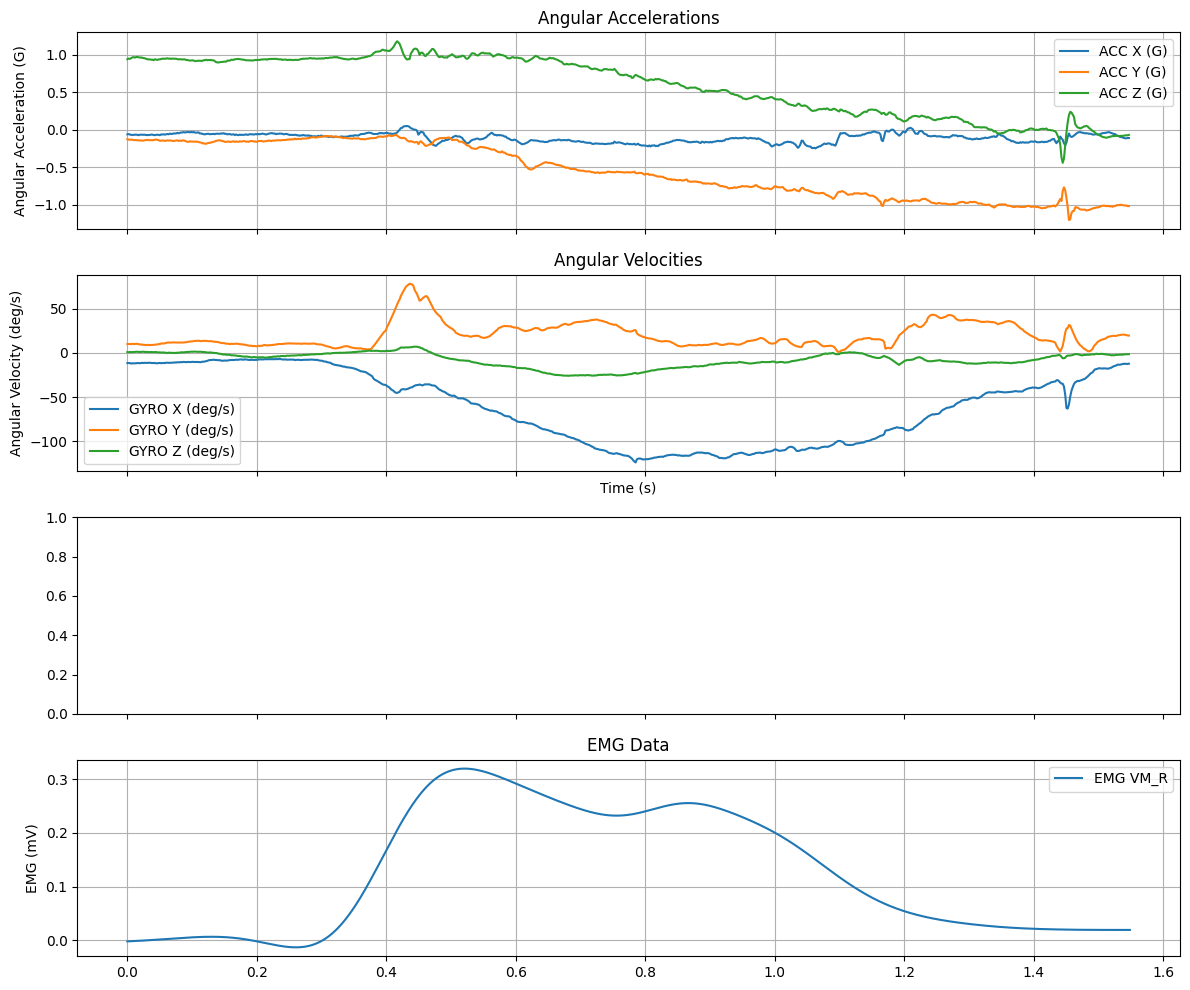

3190


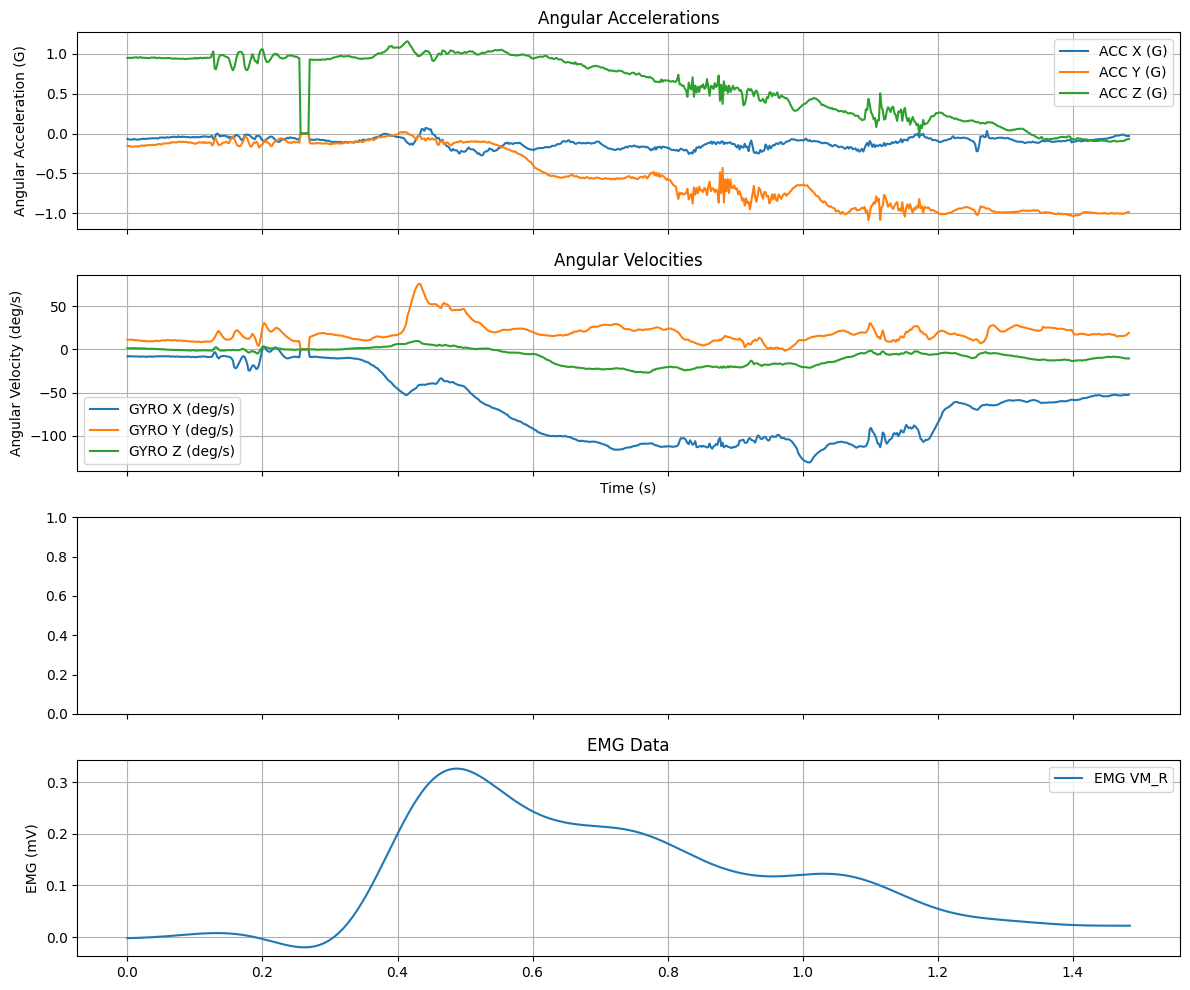

3911


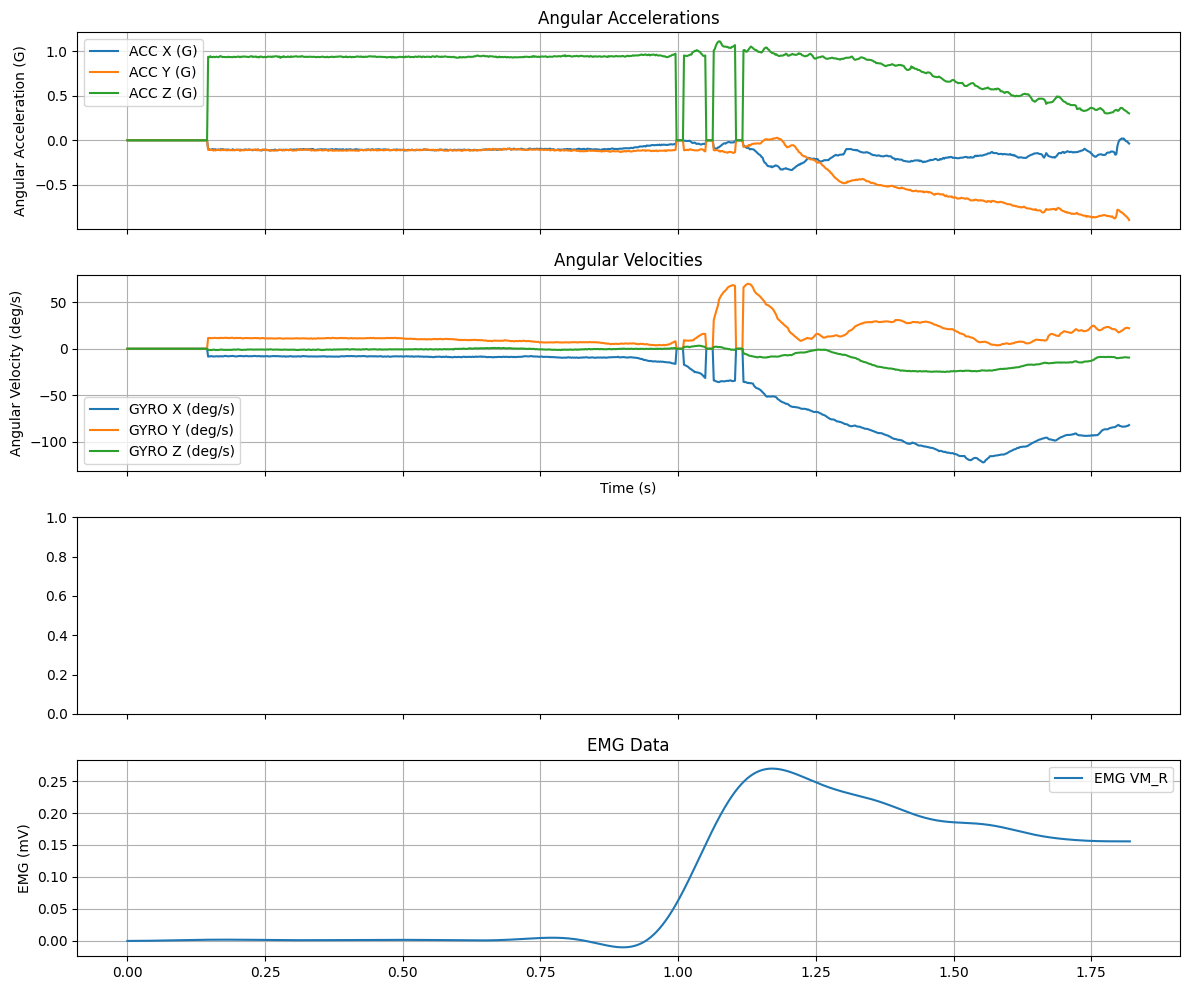

In [ ]:
# Plot the extracted segments

# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_Test_Backup_segmentation/February_20/EMG/STS")
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_Test_IMU_seg/February_20/EMG/STS")
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_Test_Optimization_IMU_segmentation/February_21/EMG/STS")
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_IMU_seg/February_21/EMG/STS")
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_test_backup_processing_2/February_21/EMG/STS")
# folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_Optimization_Dom/February_21/EMG/STS")
folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_test_mixed_processing/February_21/EMG/STS")

save_path = folder_path.parent.parent / "plots" / "Segmentation"
if not os.path.exists(save_path):
    os.makedirs(save_path)

imu_files = {}
emg_files = {}

# Iterate thorugh folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".csv"):
            tag = re.search(r"Profile_(\d+)_", file).group(1)
            if "EMG" in file:
                emg_file = load(os.path.join(folder_path, file))
                emg_files[tag] = emg_file
            if "IMU" in file:
                imu_file = load(os.path.join(folder_path, file))
                imu_files[tag] = imu_file

for tag in imu_files.keys():
    imu_df = imu_files[tag]
    emg_df = emg_files[tag]

    # Drop EMG OR and EMG IMU columns
    # emg_df = emg_df.drop(columns=['EMG OR', 'EMG IMU'])
    # emg_df = emg_df.dropna().reset_index(drop=True)

    # Filter the emg data
    emg_df, _ = filter_emg(emg_df, sfreq=2148.259)

    imu_time_interval = 1 / 518.519  # Time step based on ACC X sampling rate
    imu_df['Time (s)'] = imu_df.index * imu_time_interval

    # emg_time_interval = 1 / 1259.2593 # Time step based on EMG sampling rate
    emg_time_interval = 1 / 2148.259 # Time step based on EMG sampling rate$
    emg_df['Time (s)'] = emg_df.index * emg_time_interval  # Create a time column for EMG data

    emg_df["EMG VM_R"] = emg_df["VM_R"]

    print(len(emg_df))

    # Plot the data
    plot_segmented_data(imu_df, emg_df, file_path)
